# ING Lion's Den 2024

## Team: RiskBusters

 Michał Bryzik, Michał Niegierewicz, Kacper Gruca, Jan Ślusarek
 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve, average_precision_score, PrecisionRecallDisplay, recall_score, f1_score, precision_recall_curve, auc, classification_report, confusion_matrix, make_scorer, fbeta_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
import shap
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

### Reading the final dataset

In [20]:
df_train=pd.read_csv('../data/output/categorical_dfs/development_sample_woe.csv')
df_test=pd.read_csv('../data/output/categorical_dfs/testing_sample_woe_after_right_filling.csv')

### Separating features and target variable

In [21]:
X = df_train.drop('target', axis=1)
y = df_train['target']
X_t = df_test.drop('target', axis=1)
y_t = df_test['target']

### Setting up resamplers [old code]

In [22]:
resmaplers = {
    #'SMOTE': SMOTE(random_state=123),
    #'RandomOverSampler': RandomOverSampler(random_state=123)
    #'ADASYN': ADASYN(random_state=123),
    'RandomUnderSampler': RandomUnderSampler(random_state=123)
    #'NearMiss': NearMiss(version=1, n_neighbors=3)
}

### Specifying models and grids of parameters for grid search

In [23]:
models = {
    'Random Forest': RandomForestClassifier(random_state=123),
    'XGBoost': XGBClassifier(random_state=123, n_jobs=-1, objective='binary:logistic'),
    'LightGBM': LGBMClassifier(random_state=123),
    'SVC': SVC(probability=True, random_state=123),
    'CatBoost': CatBoostClassifier(random_state=123, verbose=0),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=123, max_iter = 1000)
}

# Define parameter grids for each model
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'learning_rate': [0.04, 0.05, 0.6],
    'n_estimators': [60,80,100],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

param_grid_lgbm = {
    'learning_rate': [0.04, 0.05, 0.6],
    'n_estimators': [60,80, 100],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

param_grid_svc = {
    'C': [0.9,1,1.1],
    'gamma': [0.1, 1, 'scale', 'auto']
}

param_grid_catboost = {
    'iterations': [60,80, 100],
    'learning_rate': [0.005,0.01],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'auto_class_weights': ['None', 'Balanced'],
}

param_grid_knn = {
    'n_neighbors': [9,14,17,20],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

param_grid_logreg = {
    'C': [ 0.09, 0.1, 1.1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

### Rescaling/Resampling variables

As before it was done in the loop [multiple resamplers] and rescaled [because of using continous variables], but at the end we have used one resampler and haven't scaled the variables because of WoE approach.

In [25]:
rus = RandomUnderSampler(random_state=123)
#scaler = StandardScaler()
X_train_scaled =X #scaler.fit_transform(X)
X_t_scaled =X_t #scaler.transform(X_t)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y)

### Machine Learning approach


Training model: Random Forest

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92      3427
         1.0       0.10      0.43      0.16       119

    accuracy                           0.85      3546
   macro avg       0.54      0.65      0.54      3546
weighted avg       0.95      0.85      0.89      3546


Training model: XGBoost

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88      3427
         1.0       0.09      0.55      0.15       119

    accuracy                           0.79      3546
   macro avg       0.53      0.67      0.51      3546
weighted avg       0.95      0.79      0.86      3546


Training model: LightGBM

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.79      0.88      3427
         1.0       0.08      0.54      0.14       119

    accuracy                

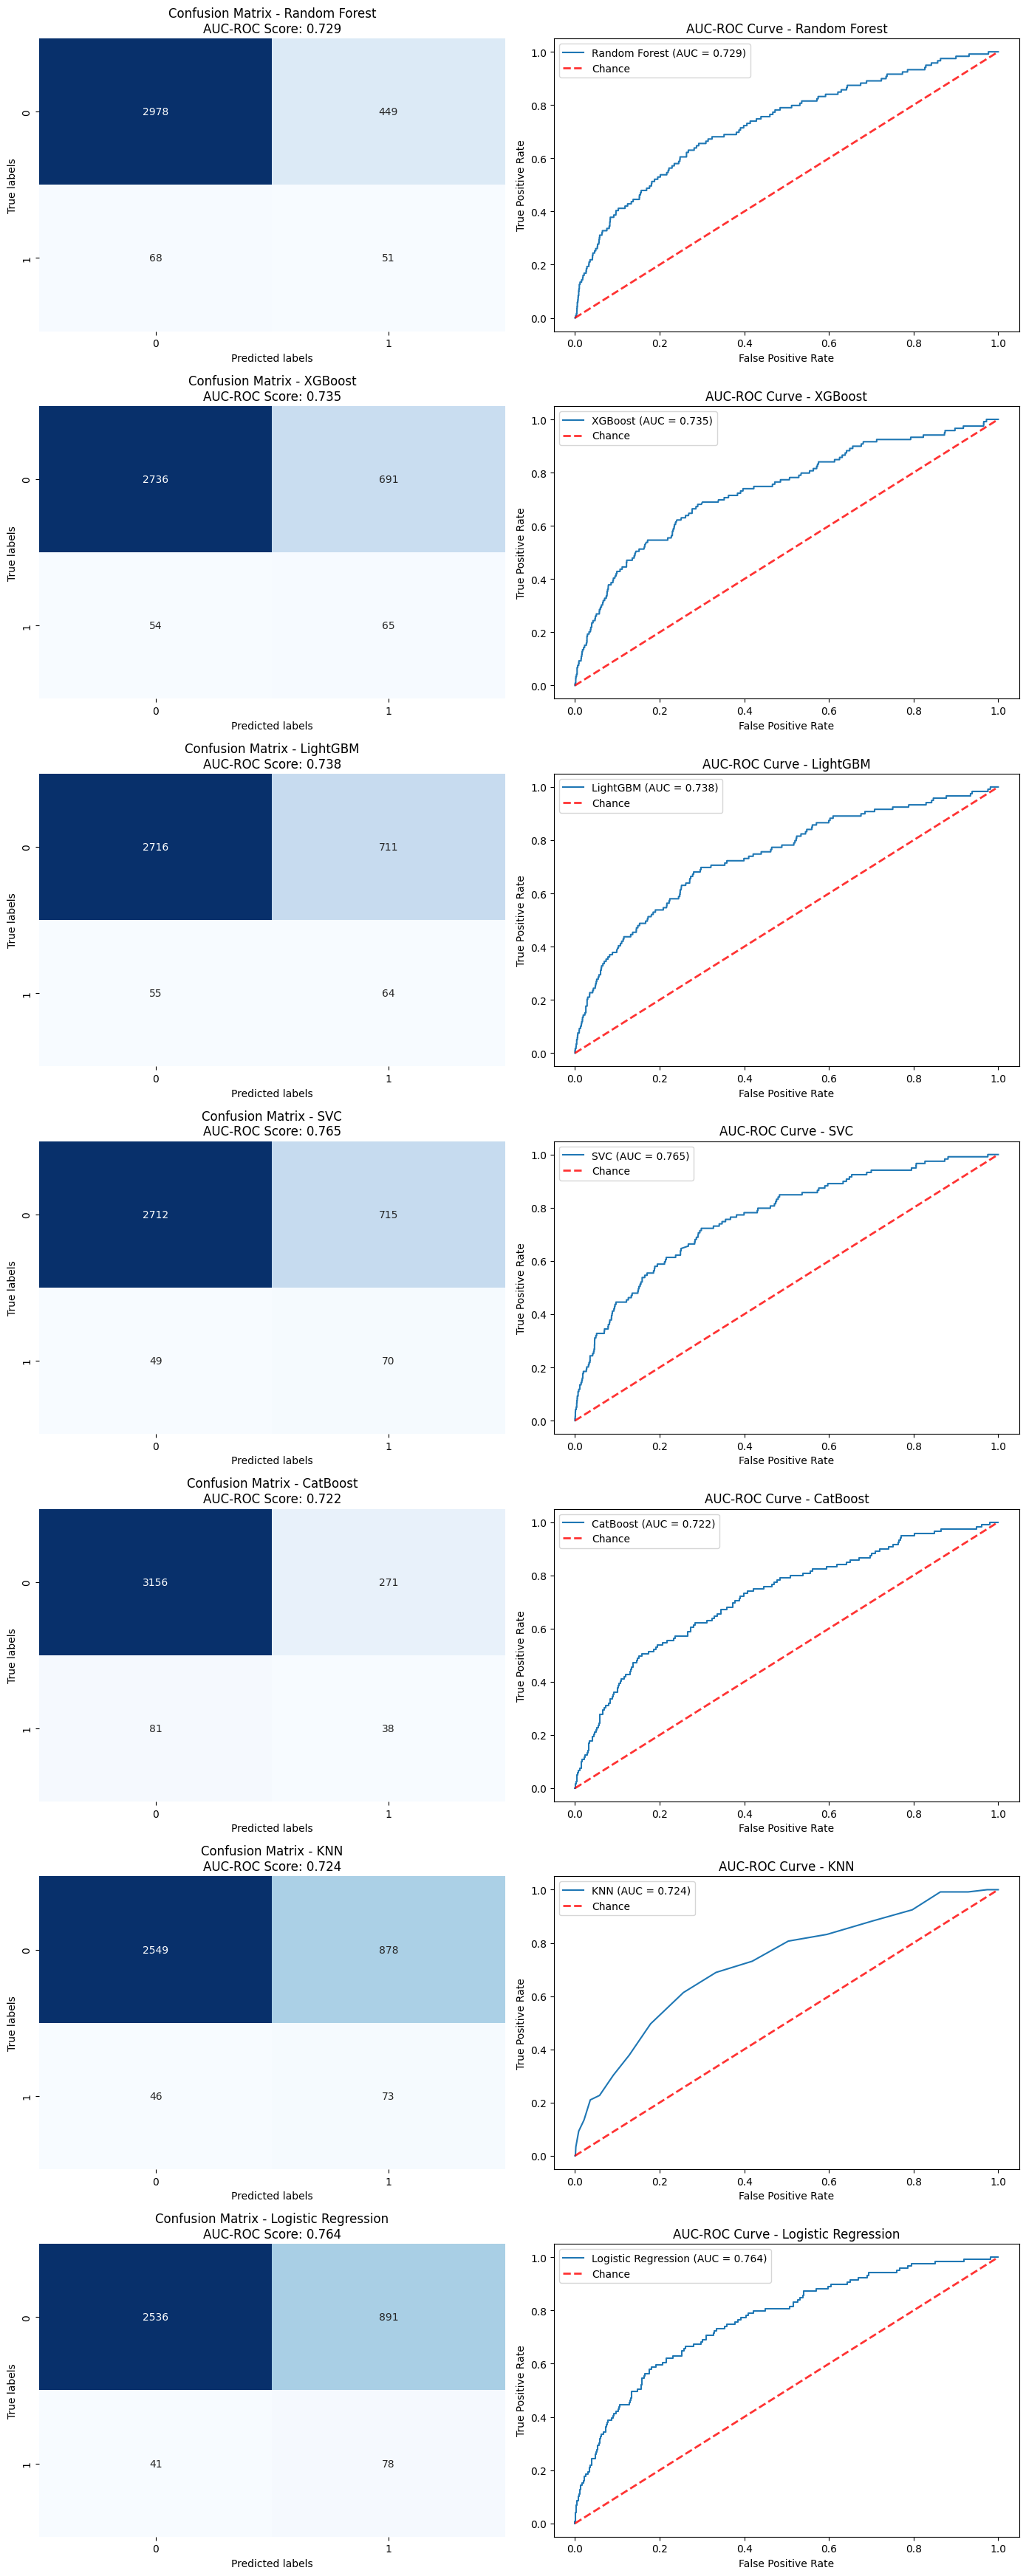


Results Table:


,Model_name,Parameters,CV_score,Test_score
0,Random Forest,"{'max_depth': 4, 'min_samples_split': 10, 'n_e...",0.645520,0.728573
1,XGBoost,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.645607,0.735386
2,LightGBM,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.649079,0.737941
3,SVC,"{'C': 0.9, 'gamma': 'auto'}",0.728674,0.765077
4,CatBoost,"{'auto_class_weights': 'Balanced', 'depth': 4,...",0.641499,0.721608
5,KNN,"{'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}",0.699857,0.723661
6,Logistic Regression,"{'C': 1.1, 'penalty': 'l1', 'solver': 'saga'}",0.733388,0.764083


In [26]:
from sklearn.model_selection import cross_val_score
from IPython.display import display
results = []
best_models = {} 
plt.figure(figsize=(14, 35))
for i, (name, model) in enumerate(models.items(), 1):
    print(f"\nTraining model: {name}")
    
    # Initialize GridSearchCV with the model and it's parameter grid
    if name == 'Random Forest':
        grid_search = GridSearchCV(model, param_grid_rf, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    elif name == 'XGBoost':
        grid_search = GridSearchCV(model, param_grid_xgb, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    elif name == 'LightGBM':
        grid_search = GridSearchCV(model, param_grid_lgbm, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    elif name == 'SVC':
        grid_search = GridSearchCV(model, param_grid_svc, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    elif name == 'CatBoost':
        grid_search = GridSearchCV(model, param_grid_catboost, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    elif name == 'KNN':
        grid_search = GridSearchCV(model, param_grid_knn, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    elif name == 'Logistic Regression':
        grid_search = GridSearchCV(model, param_grid_logreg, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    
    # Fitting Grid Search on the resampled data
    grid_search.fit(X_resampled, y_resampled)
    
    # Get the best parameters and the best model
    best_params = grid_search.best_params_
    best_model = model.set_params(**best_params)
    best_model.fit(X_resampled, y_resampled)
    best_models[name] = best_model

    # Calculate AUC-ROC
    y_prob = best_model.predict_proba(X_t_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_t, y_prob)
    auc_roc = roc_auc_score(y_t, y_prob)
    
    # Print classification report
    print("\nClassification Report:")
    y_pred = best_model.predict(X_t_scaled)
    print(classification_report(y_t, y_pred))
    
    # Plot Confusion Matrix
    plt.subplot(7, 2, 2*i-1)
    cm = confusion_matrix(y_t, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {name}\nAUC-ROC Score: {auc_roc:.3f}')
    
    # Plot AUC-ROC Curve
    plt.subplot(7, 2, 2*i)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_roc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUC-ROC Curve - {name}')
    plt.legend()

    # Calculate cross-validated score
    cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=3, scoring='roc_auc')
    cv_score_mean = cv_scores.mean()
    
    # Calculate final test score
    test_score = roc_auc_score(y_t, y_prob)
    
    results.append({
        'Model_name': name,
        'Parameters': str(best_params),
        'CV_score': cv_score_mean,
        'Test_score': test_score
    })

    

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nResults Table:")
display(results_df)




### Results interpretability [XGBoost example]

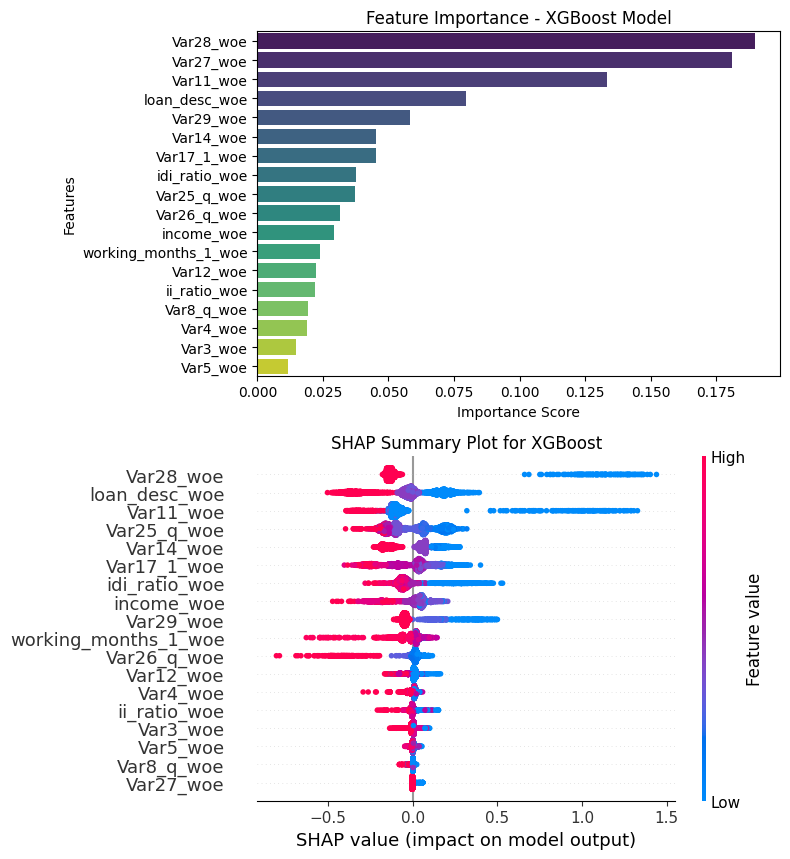

In [27]:
# Example on XGBoost model
best_xgb_model = best_models['XGBoost']

# Get feature importances
importances = best_xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Calculate SHAP values
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_t_scaled)

# Plot Importances
plt.figure(figsize=(20, 12))
plt.subplot(2, 1, 1)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - XGBoost Model')

# Plot SHAP values
plt.subplot(2, 1, 2)
shap.summary_plot(shap_values, X_t_scaled, feature_names=X.columns, show=False)
plt.title(f'SHAP Summary Plot for XGBoost')

plt.tight_layout()
plt.show()
